In [1]:
import numpy as np
import pandas as pd

import geopandas as gpd

import psycopg2
from fiona.crs import from_epsg

from netrc import netrc
user, acct, passwd = netrc().authenticators("harris")

import requests

import statsmodels.formula.api as smf

import pysal as ps

from scipy.stats import pearsonr

from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt

import os

from IPython.display import display

import networkx as nx


%matplotlib inline

### Helper function to vizualize weights matrices.

In [2]:
def w2line_graph(w, df, lw = 0.05):
    
    ctrs = np.array([pt.coords[0] for pt in df.centroid])
    
    segments = []
    for i in w.id_order:
        origin = ctrs[i]
        for j in w.neighbors[i]:
            if j == i: continue
            segments.append([origin, ctrs[j]])

    lc_segs = LineCollection(segments)
    lc_segs.set_linewidth(lw)

    return lc_segs


### Move from pysal to networkx

In [47]:
def w2dwg(w):
    
    G = nx.DiGraph()
    G.add_weighted_edges_from([(i,j,w[i][j]) for i in w.neighbors for j in w[i]])
    
    for e0, e1 in G.edges():
        if not G[e0][e1]["weight"]:
            G[e0][e1]["distance"] = float('inf')
        else: 
            G[e0][e1]["distance"] = 1 / G[e0][e1]["weight"]

    return G

In [4]:
def summed_undirected(G):

    ug = G.to_undirected()

    for e0, e1 in ug.edges(): ug.edges[e0, e1]["weight"] = 0

    for e0, e1 in G.edges():

        e_min = e0 if e0 < e1 else e1
        e_max = e0 if e0 > e1 else e1

        ug.edges[e_min, e_max]["weight"] += G.edges[e0, e1]["weight"]
        
    return ug

### Generate shared-perimeter weights.

In [5]:
def spw_from_dataframe(df, norm = False):
    
    spw = {}
    
    queen = ps.weights.Queen.from_dataframe(df)
    
    for x, neighbors in queen.neighbors.items():
        
        spw[x] = []
        for n in neighbors:
            spw[x].append(df.iloc[x].geometry.intersection(df.iloc[n].geometry).length)

        if norm: 
            shared_borders = sum(spw[x])
            for ni in range(len(spw[x])):
                spw[x][ni] /= shared_borders

    return ps.W(queen.neighbors, spw)


### Invisible Walls

In [242]:
def invisible_walls(df, w, spw):

    ratio = []
    geometry = []
    for x, neighbors in spw.neighbors.items():
        
        # The node does have to be in there.
        if x not in w.neighbors: continue
    
        # If they are part of the same region, 
        # compare the (averaged) interactions and perimeter.
        for n in neighbors:
            
            # Only visit the weights once.
            if x > n: continue
                
            # If they don't actually share perimeter...
            if not spw[n][x]: continue
                
            # or the neighbor is not in the region...
            if n not in df.index: continue
            if x not in df.index: continue
            
            value = 0
            if x in w.neighbors and n in w.neighbors[x]:
                value += w[x][n]

            if n in w.neighbors and x in w.neighbors[n]:
                value += w[n][x]
            
            value /= spw[n][x] + spw[x][n]
            
            ratio.append([value])
            geometry.append(df.loc[x].geometry.intersection(df.loc[n].geometry))
            
    walls = gpd.GeoDataFrame(data = ratio, columns = ["Ratio"], geometry = geometry, crs = df.crs)
    walls["q"] = walls.Ratio.rank() / walls.shape[0]

    return walls


In [6]:
chicago = gpd.read_postgis("SELECT state, county, tract, "
                           "state::bigint * 1000000000 + county * 1000000 + tract geoid, "
                           "geom geometry FROM census_tracts_2015 "
                           # "WHERE ST_DWithin(centroid, ST_Transform(ST_SetSRID(ST_MakePoint(-87.6009453, 41.7907761), 4269), 2163), 200000) "
                           "WHERE ST_Intersects(ST_MakeEnvelope(-88.3, 41.57, -87.3, 42, 4326), ST_Transform(geom, 4326)) OR (state = 17 AND county = 31)"
                           "ORDER BY state, county, tract;",
                           con = psycopg2.connect(database = "census", user = user, password = passwd,
                                                  host = "saxon.harris.uchicago.edu", port = 5432),
                           geom_col = "geometry", crs = from_epsg(2163)).to_crs(epsg = 3528)

rev_dict = {v : k for k, v in chicago.geoid.to_dict().items()}

In [7]:
lodes = pd.read_csv("../lodes/chicagoland_working_adjacency.csv",
                    names = ["a_state", "a_county", "a_tract",
                             "b_state", "b_county", "b_tract", 
                             "link", "loglink"])

lodes["a_idx"] = lodes.a_state * 1000000000 + lodes.a_county * 1000000 + lodes.a_tract
lodes["b_idx"] = lodes.b_state * 1000000000 + lodes.b_county * 1000000 + lodes.b_tract
lodes.drop(["a_state", "a_county", "a_tract", "b_state", "b_county", "b_tract", "loglink"], axis = 1, inplace = True)

# lodes = lodes.loc[(lodes.a_state == 17) & (lodes.a_county == 31) & 
#                   (lodes.b_state == 17) & (lodes.b_county == 31) & 
#                   (lodes.a_tract != 990000) & (lodes.b_tract != 990000), # Lake Michigan
#                   ["a_tract", "b_tract", "link"]]

lodes["a_idx"] = lodes["a_idx"].map(rev_dict)
lodes["b_idx"] = lodes["b_idx"].map(rev_dict)
lodes.dropna(inplace = True)

lodes["a_idx"] = lodes["a_idx"].astype(int)
lodes["b_idx"] = lodes["b_idx"].astype(int)

lodes.loc[lodes.a_idx == lodes.b_idx, "link"] = 0

mlodes = lodes.pivot(index = "a_idx", columns = "b_idx", values = "link").fillna(0).sort_index()
mlodes = mlodes[list(mlodes.index)]
mlodes = mlodes.div(mlodes.sum(axis=1), axis=0)

del lodes

In [8]:
traces = pd.read_csv("c_adjacencies.csv", names = ["A", "B", "link"])

# traces["a_state"]  = traces["A"] // 1000000000
# traces["a_county"] = (traces["A"] // 1000000) % 1000
# traces["a_tract"]  = traces["A"] % 1000000

# traces["b_state"]  = traces["B"] // 1000000000
# traces["b_county"] = (traces["B"] // 1000000) % 1000
# traces["b_tract"]  = traces["B"] % 1000000

# traces = traces.loc[(traces.a_state == 17) & (traces.a_county == 31) & 
#                     (traces.b_state == 17) & (traces.b_county == 31),
#                     ["a_tract", "b_tract", "link"]]

traces = traces[~traces.A.isin([17031980000, 17031980100])]

traces["a_idx"] = traces["A"].map(rev_dict)
traces["b_idx"] = traces["B"].map(rev_dict)
traces = traces[["a_idx", "b_idx", "link"]]

traces.dropna(inplace = True)

traces["a_idx"] = traces["a_idx"].astype(int)
traces["b_idx"] = traces["b_idx"].astype(int)

traces = traces[~traces.a_idx.isnull() & ~traces.a_idx.isnull()]
traces.loc[traces.a_idx == traces.b_idx, "link"] = 0

# Drop Midway and O'Hare

mtraces = traces.pivot(index = "a_idx", columns = "b_idx", values = "link").fillna(0).sort_index()

mtraces = mtraces[list(mtraces.index)]
mtraces = mtraces.div(mtraces.sum(axis=1), axis=0)

In [9]:
def transform_matrix_weights(matrix, N = 10):
    
    neighbors = {}
    weights   = {}
    
    potential_links = {}
    for idx in matrix.index:

        link = matrix.loc[idx].sort_values(ascending = False).copy()
        total = link.sum()
        link /= total
        
        if N: link = link[:N]

        link = np.power(2, link)

        neighbors[idx] = list(link.index)
        weights[idx]   = list(link.loc[neighbors[idx]])

    return ps.W(neighbors, weights)
        

In [10]:
def product_matrix_weights(matrix, N = 10):
    
    neighbors = {}
    weights   = {}
    
    potential_links = {}
    for idx in matrix.index:

        product = matrix.loc[idx] * matrix[idx]
        product.sort_values(ascending = False, inplace = True)
        
        if N: product = product[:N]

        neighbors[idx] = list(product.index)
        weights[idx]   = list(product.loc[neighbors[idx]])

    return ps.W(neighbors, weights)
        

In [11]:
def trim_matrix_weights(matrix, symmetric = True, threshold = 0, N = 0):
    
    neighbors = {}
    weights   = {}
    
    potential_links = {}
    for aidx in matrix.index:

        link = matrix.loc[aidx].sort_values(ascending = False).copy()
        total = link.sum()
        link /= total

        if threshold: link = link[link > threshold]
        if N:         link = link[:N]
            
        potential_links[aidx] = link.copy()
                
    for aidx, link in potential_links.items():
        
        # if aidx > 0 : break
            
        a_neighbors = []
        a_weights   = []

        for bidx in link.index:
            
            if symmetric and (aidx not in potential_links[bidx].index):
                continue
            
            a_neighbors.append(bidx)
            a_weights  .append(link.loc[bidx])
            
            # print(aidx, bidx, links.loc[bidx])
            
        # renormalize after trimming.
        total = sum(a_weights)
        a_weights = [w / total for w in a_weights]

        neighbors[aidx] = a_neighbors
        weights[aidx]   = a_weights
        # print(aidx, neighbors[aidx], weights[aidx])

    return ps.W(neighbors, weights)
        

In [12]:
weights = {}
weights["kernel"]        = ps.weights.Kernel.from_dataframe(chicago, k = 8, fixed = False, function='gaussian')
weights["knn"]           = ps.weights.KNN.from_dataframe(chicago, k = 8)
weights["dist"]          = ps.weights.DistanceBand.from_dataframe(chicago, threshold = 2000, silent = True)
weights["queen"]         = ps.weights.Queen.from_dataframe(chicago)
weights["rook"]          = ps.weights.Rook.from_dataframe(chicago)
weights["spw"]           = spw_from_dataframe(chicago, norm = True)
weights["lodes"]         = trim_matrix_weights(mlodes, N = 10, symmetric = False)
weights["traces"]        = trim_matrix_weights(mtraces, N = 10, symmetric = False)
weights["lodes_transf"]  = transform_matrix_weights(mlodes)
weights["traces_transf"] = transform_matrix_weights(mtraces)
weights["lodes_prod"]    = product_matrix_weights(mlodes, 8)
weights["traces_prod"]   = product_matrix_weights(mtraces, 8)

for x in range(len(weights["kernel"].weights)):
    weights["kernel"].weights[x][0] = 0

In [19]:
with open("traces_prod.csv", "w") as out:
    for i in weights["traces_prod"].neighbors:
        for j in weights["traces_prod"][i]:
            out.write("{} {}\n".format(i,j))

In [13]:
for w in weights:

    ax = chicago.plot(facecolor = "#99DDFF", alpha = 0.2, edgecolor = "#224466", linewidth = 0.2, zorder = -1)
    ax.add_collection(w2line_graph(weights[w], chicago, lw = 0.05))

    ax.set_title(w.replace("_", " ").title())

    map_format(ax)
    ax.figure.savefig("figs/chicago_{}.pdf".format(w))

    plt.close("all")
    
os.system("pdftk figs/chicago_rook.pdf figs/chicago_queen.pdf figs/chicago_knn.pdf figs/chicago_lodes*.pdf figs/chicago_traces*.pdf cat output figs/chicago_weights.pdf")

0

In [14]:
census = pd.read_csv("ana_data/chicago_base_vars.csv",
                     usecols = ["GEOID", "PCT_UNEMP", "MHI", "POV_PCT"]).dropna()
census.rename(columns = {"GEOID" : "geoid"}, inplace = True)

x = pd.merge(chicago, census, how = "left")
x["MHI"].fillna(x.MHI.mean(), inplace = True)
x["POV_PCT"].fillna(x.POV_PCT.mean(), inplace = True)
x["PCT_UNEMP"].fillna(x.PCT_UNEMP.mean(), inplace = True)
x.set_index(x.geoid.map(rev_dict), inplace = True)

In [15]:
pd.options.display.precision = 2

for obs in ["PCT_UNEMP", "MHI", "POV_PCT"]:

    table = []
    for w in ["queen", "rook", "spw", "knn", "kernel",
              "lodes", "lodes_transf", "lodes_prod", 
              "traces", "traces_transf", "traces_prod",]:
        
        tridx = set(weights[w].weights.keys())

        R2 = pearsonr(x.loc[tridx, obs], ps.lag_spatial(weights[w], x.loc[tridx, obs]))[0]
        I = ps.Moran(x.loc[tridx, obs], weights[w])
        C = ps.Geary(x.loc[tridx, obs], weights[w])
        
        table.append([w.replace("_", " ").title(), 
                      R2, I.I, round(I.z_sim, 1), C.C, round(C.z_sim, 1)])
        
    display(pd.DataFrame(table, columns = [obs, "R²", "I", "z_I", "C", "z_C"]).set_index(obs))
        
    print()

,R²,I,z_I,C,z_C
PCT_UNEMP,,,,,
Queen,0.73,0.67,48.3,0.33,-37.6
Rook,0.68,0.67,42.6,0.33,-33.4
Spw,0.79,0.67,39.2,0.32,-32.6
Knn,0.80,0.67,56.5,0.34,-44.8
Kernel,0.80,0.67,57.3,0.34,-45.7
Lodes,0.70,0.27,32.4,0.49,-2.3
Lodes Transf,0.72,0.28,34.1,0.47,-4.9
Lodes Prod,0.07,0.49,46.8,0.33,-9.0
Traces,0.78,0.49,44.2,0.39,-9.6


,R²,I,z_I,C,z_C
MHI,,,,,
Queen,0.82,0.68,47.9,0.31,-43.1
Rook,0.83,0.69,44.4,0.30,-40.3
Spw,0.84,0.71,42.5,0.29,-38.2
Knn,0.82,0.66,59.5,0.33,-52.6
Kernel,0.83,0.67,55.6,0.32,-53.8
Lodes,0.73,0.42,51.1,0.48,-4.8
Lodes Transf,0.74,0.42,50.6,0.48,-6.3
Lodes Prod,0.82,0.63,60.6,0.31,-13.3
Traces,0.80,0.54,46.1,0.42,-11.0


,R²,I,z_I,C,z_C
POV_PCT,,,,,
Queen,0.80,0.66,48.2,0.34,-40.5
Rook,0.80,0.67,41.1,0.33,-37.9
Spw,0.80,0.68,39.6,0.32,-35.6
Knn,0.80,0.65,55.6,0.36,-49.2
Kernel,0.80,0.66,54.6,0.35,-48.7
Lodes,0.67,0.27,33.1,0.50,-4.7
Lodes Transf,0.69,0.28,35.0,0.49,-5.8
Lodes Prod,0.77,0.50,48.2,0.34,-11.0
Traces,0.77,0.48,41.5,0.41,-10.8


In [48]:
graphs = {k : w2dwg(v) for k, v in weights.items()}

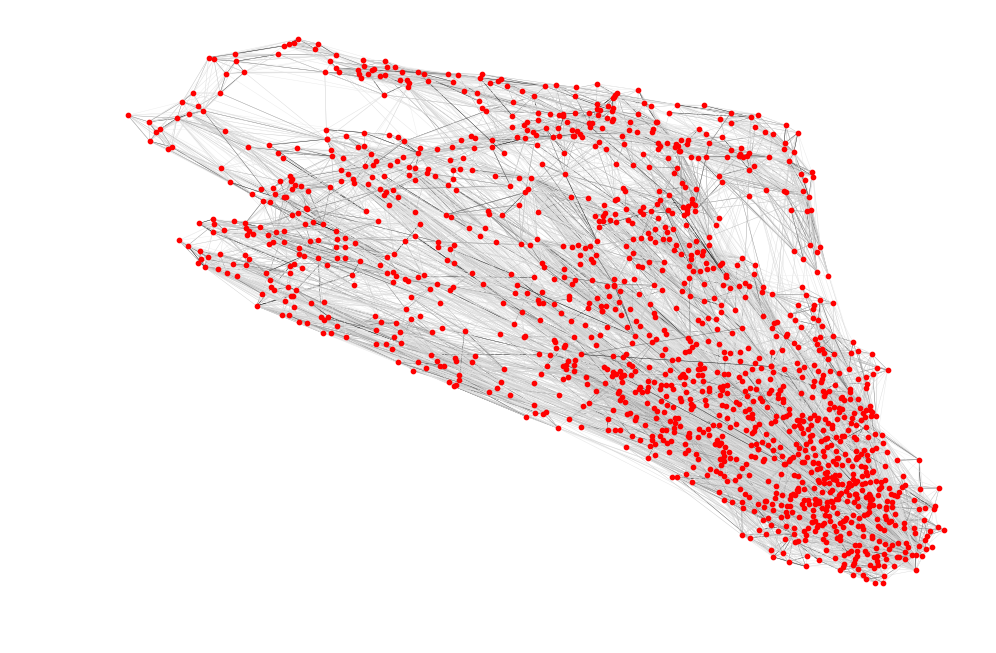

In [38]:
edge_color = np.array([graphs["traces"].edges[e0, e1]["weight"] for e0, e1 in graphs["traces"].edges()])
nx.draw_spring(graphs["traces"], 
               node_size = 3, node_color = "red", width = 0.2, arrows=False, 
               edge_color = edge_color, edge_cmap = plt.cm.Greys,
               edge_vmin = 0, edge_vmax = 0.3)

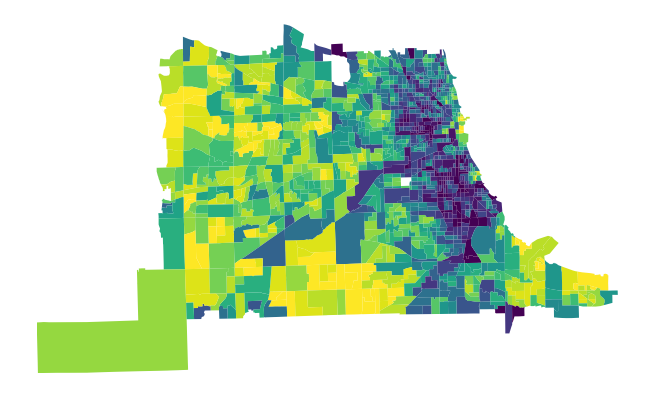

In [49]:
ug = summed_undirected(graphs["traces_prod"])
ax = chicago.join(pd.Series(name = "Clustering", data = nx.clustering(ug, weight = "weight"))).dropna()\
            .plot(column = "Clustering", figsize = (5, 5), scheme = "quantiles", k = 20)
    
map_format(ax)
ax.figure.savefig("figs/hyde_park_clustering.pdf")

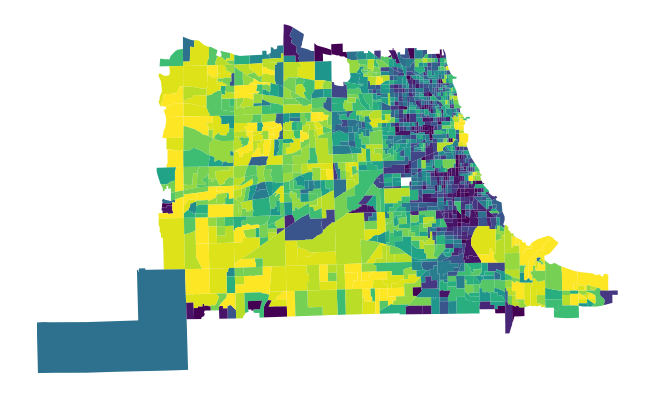

In [50]:
centrality = pd.Series(data = nx.katz_centrality(graphs["traces_prod"], max_iter = 10000, weight = "weight"), name = "centrality")
ax = chicago.join(centrality).dropna().plot(column = "centrality", figsize = (5, 5), scheme = "quantiles", k = 20)

map_format(ax)

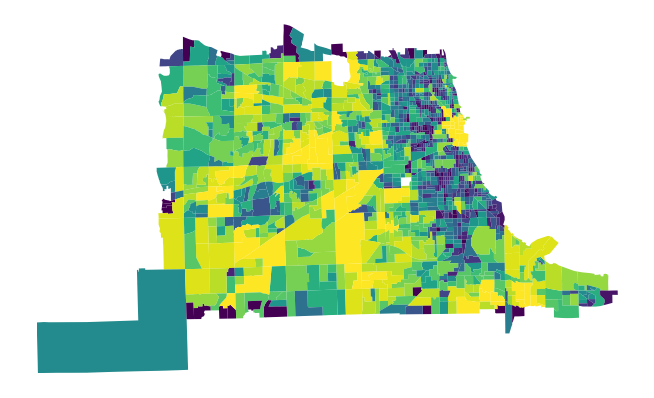

In [51]:
centrality = pd.Series(data = nx.katz_centrality(graphs["traces"], alpha = 0.9, max_iter = 10000, weight = "weight"), name = "centrality")
ax = chicago.join(centrality).dropna().plot(column = "centrality", figsize = (5, 5), scheme = "quantiles", k = 20)
    
map_format(ax)

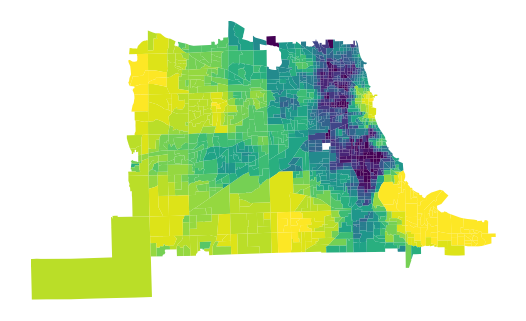

In [52]:
centrality = pd.Series(data = nx.eigenvector_centrality(graphs["traces_prod"], max_iter = 10000, weight = "weight"), name = "centrality")
ax = chicago.join(centrality).dropna().plot(column = "centrality", figsize = (4, 4), scheme = "quantiles", k = 20)
    
map_format(ax)

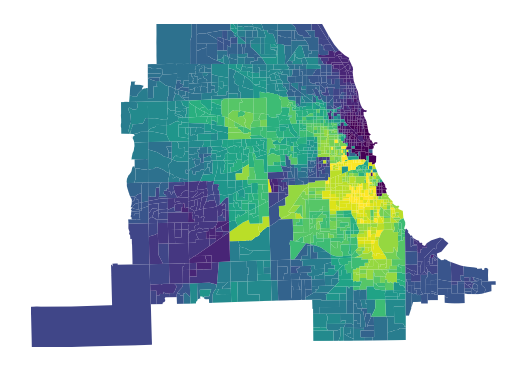

In [63]:
centrality = pd.Series(data = nx.closeness_centrality(graphs["lodes"], distance = "distance"), name = "centrality")
ax = chicago.join(centrality).dropna().plot(column = "centrality", figsize = (4, 4), scheme = "quantiles", k = 20)
    
map_format(ax)

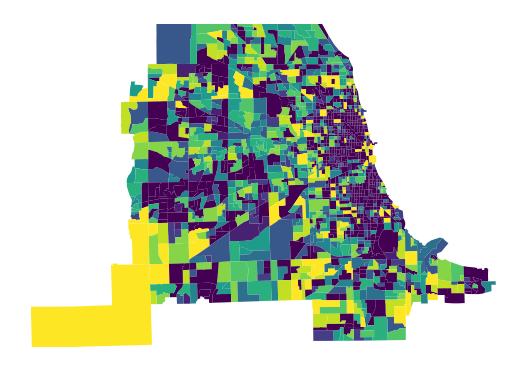

In [54]:
centrality = pd.Series(data = nx.katz_centrality(graphs["lodes"], max_iter = 10000, weight = "weight"), name = "centrality")
ax = chicago.join(centrality).dropna().plot(column = "centrality", figsize = (4, 4), scheme = "quantiles", k = 20)
    
map_format(ax)

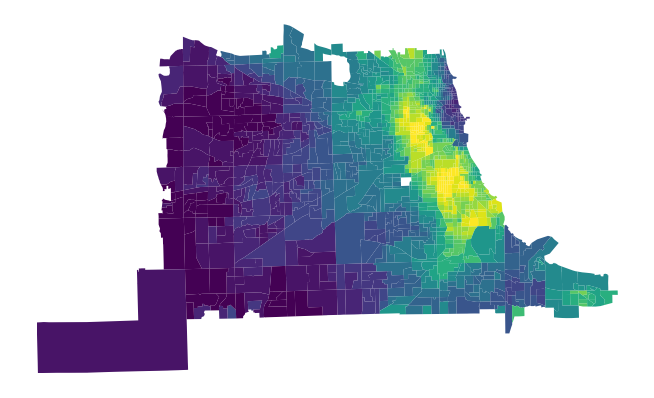

In [55]:
ax = chicago.join(pd.Series(name = "Clustering", 
                            data = nx.closeness_centrality(graphs["traces"], distance = "distance"))).dropna()\
            .plot(column = "Clustering", figsize = (5, 5), scheme = "quantiles", k = 20)
    
map_format(ax)

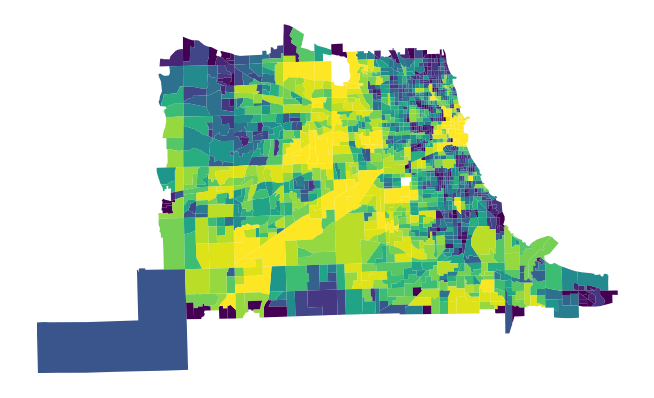

In [56]:
ax = chicago.join(pd.Series(name = "Clustering", 
                            data = nx.harmonic_centrality(graphs["traces"], distance = "distance"))).dropna()\
            .plot(column = "Clustering", figsize = (5, 5), scheme = "quantiles", k = 20)
    
map_format(ax)

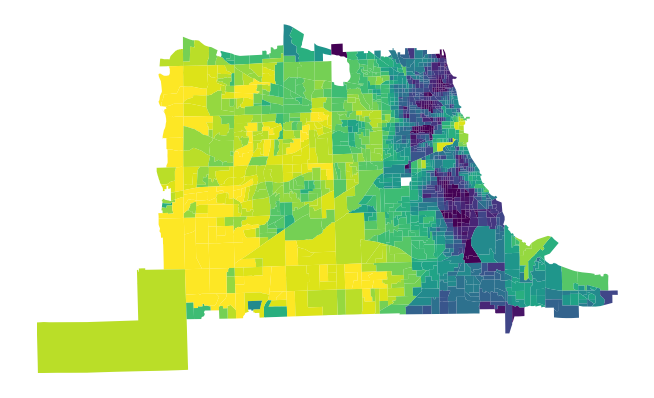

In [57]:
ax = chicago.join(pd.Series(name = "Clustering", data = nx.harmonic_centrality(graphs["traces_prod"], distance = "distance"))).dropna()\
            .plot(column = "Clustering", figsize = (5, 5), scheme = "quantiles", k = 20)
    
map_format(ax)

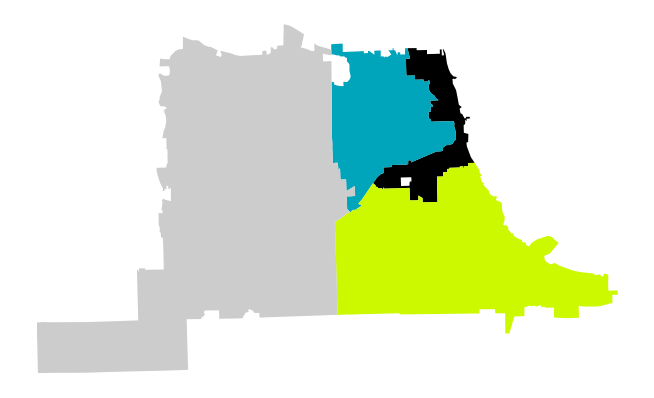

In [58]:
CNM = pd.read_csv("snap/traces_prod_cnm.csv", names = ["idx", "CNM"], index_col = "idx")

ax = chicago.join(CNM).dropna().dissolve("CNM")\
            .plot(figsize = (5, 5), scheme = "quantiles", k = 20, cmap = "nipy_spectral")
    
map_format(ax)

In [59]:
from networkx.algorithms import community
from networkx import edge_betweenness_centrality as betweenness

In [60]:
def most_central_edge(G):
    centrality = betweenness(G, weight='weight')
    return max(centrality, key=centrality.get)

GN = community.girvan_newman(graphs["traces_prod"], most_valuable_edge=most_central_edge)
# P = next(GN)

In [61]:
# ug = summed_undirected(graphs["traces_prod"])
# kl = community.kernighan_lin_bisection(ug, max_iter = 10)

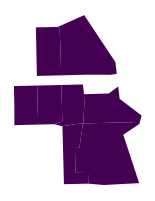

In [62]:
ax = chicago.join(pd.Series(name = "Dispersion", 
                            data = nx.dispersion(graphs["lodes_prod"], rev_dict[17031411200])))\
            .dropna().plot(column = "Dispersion", figsize = (1.5, 1.5))
    
map_format(ax)

In [ ]:
walls = invisible_walls(chicago.loc[weights["traces_prod"].neighbors], weights["traces_prod"], weights["spw"])

ax = chicago.loc[weights["traces_prod"].neighbors].plot(color = "0.5")
walls[walls.q > 0.2].plot(color = "white", linewidth = 0.05, ax = ax)

walls[walls.q < 0.2].plot(column = "q", linewidth = 0.5, ax = ax, cmap = "Reds_r")
map_format(ax)
ax.figure.savefig("figs/invisible_walls.pdf")